##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single timestep:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [2]:
import os

os.environ['CUDA_DEVICE_ORDER']    ='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (20, 20)
mpl.rcParams['axes.grid'] = False

In [3]:
# import timeseries_dataset_from_array

In [4]:
from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.util.tf_export import keras_export

def timeseries_dataset_from_array(
    data,
    targets,
    sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None):
  
    # Validate the shape of data and targets
    if targets is not None and len(targets) != len(data):
        raise ValueError('Expected data and targets to have the same number of '
                         'time steps (axis 0) but got '
                         'shape(data) = %s; shape(targets) = %s.' %
                         (data.shape, targets.shape))
    if start_index and (start_index < 0 or start_index >= len(data)):
        raise ValueError('start_index must be higher than 0 and lower than the '
                         'length of the data. Got: start_index=%s '
                         'for data of length %s.' % (start_index, len(data)))
    if end_index:
        if start_index and end_index <= start_index:
            raise ValueError('end_index must be higher than start_index. Got: '
                           'start_index=%s, end_index=%s.' %
                           (start_index, end_index))
        if end_index >= len(data):
            raise ValueError('end_index must be lower than the length of the data. '
                           'Got: end_index=%s' % (end_index,))
        if end_index <= 0:
            raise ValueError('end_index must be higher than 0. '
                           'Got: end_index=%s' % (end_index,))

    # Validate strides
    if sampling_rate <= 0 or sampling_rate >= len(data):
        raise ValueError(
            'sampling_rate must be higher than 0 and lower than '
            'the length of the data. Got: '
            'sampling_rate=%s for data of length %s.' % (sampling_rate, len(data)))
    if sequence_stride <= 0 or sequence_stride >= len(data):
        raise ValueError(
            'sequence_stride must be higher than 0 and lower than '
            'the length of the data. Got: sequence_stride=%s '
            'for data of length %s.' % (sequence_stride, len(data)))

    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(data)

    # Determine the lowest dtype to store start positions (to lower memory usage).
    num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
    if num_seqs < 2147483647:
        index_dtype = 'int32'
    else:
        index_dtype = 'int64'

    # Generate start positions
    start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
    if shuffle:
        if seed is None:
            seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(start_positions)

    sequence_length = math_ops.cast(sequence_length, dtype=index_dtype)
    sampling_rate = math_ops.cast(sampling_rate, dtype=index_dtype)

    positions_ds = dataset_ops.Dataset.from_tensors(start_positions).repeat()

    # For each initial window position, generates indices of the window elements
    indices = dataset_ops.Dataset.zip(
      (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
          lambda i, positions: math_ops.range(  # pylint: disable=g-long-lambda
              positions[i],
              positions[i] + sequence_length * sampling_rate,
              sampling_rate),
          num_parallel_calls=dataset_ops.AUTOTUNE)

    dataset = sequences_from_indices(data, indices, start_index, end_index)
    if targets is not None:
        indices = dataset_ops.Dataset.zip(
            (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                lambda i, positions: positions[i],
                num_parallel_calls=dataset_ops.AUTOTUNE)
        target_ds = sequences_from_indices(
            targets, indices, start_index, end_index)
        dataset = dataset_ops.Dataset.zip((dataset, target_ds))
    if shuffle:
        # Shuffle locally at each iteration
        dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
    return dataset


def sequences_from_indices(array, indices_ds, start_index, end_index):
    dataset = dataset_ops.Dataset.from_tensors(array[start_index : end_index])
    dataset = dataset_ops.Dataset.zip((dataset.repeat(), indices_ds)).map(
      lambda steps, inds: array_ops.gather(steps, inds),  # pylint: disable=unnecessary-lambda
      num_parallel_calls=dataset_ops.AUTOTUNE)
    return dataset

In [32]:
data = np.array(conv_window.train_df, dtype=np.float32)
sequence_length=conv_window.total_window_size
batch_size=32

sampling_rate=1
sequence_stride=1
start_index = 0
end_index = len(data)

num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
start_positions = np.arange(0, num_seqs, sequence_stride)

# rng = np.random.RandomState(1)
# rng.shuffle(start_positions)
positions_ds = dataset_ops.Dataset.from_tensors(start_positions).repeat()

# comprehension

In [28]:
data

array([[-1.5684885 ,  1.2350861 , -0.91058654],
       [-1.5684885 ,  5.0894217 , -0.91058654],
       [-1.5902554 ,  4.0227237 , -0.91058654],
       ...,
       [ 0.10756139, -0.08761948,  2.4342592 ],
       [ 0.10756139,  0.06882956,  2.4342592 ],
       [ 0.12932827, -0.18717797,  2.4528418 ]], dtype=float32)

In [29]:
len(start_positions)

165485

In [33]:
indices = dataset_ops.Dataset.zip((dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
      lambda i, positions: math_ops.range(  # pylint: disable=g-long-lambda
          positions[i],
          positions[i] + sequence_length * sampling_rate,
          sampling_rate),
      num_parallel_calls=dataset_ops.AUTOTUNE)

In [35]:
k=0
for indice in indices:
    print(indice)
    k=k+1
    if k==3:
        break

tf.Tensor(
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200], shape=(201,), dtype=int64)
tf.Tensor(
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33

In [36]:
dataset = dataset_ops.Dataset.from_tensors(data)
dataset

<DatasetV1Adapter shapes: (165685, 3), types: tf.float32>

## The spider data set
This tutorial uses a <a href="https://physionet.org/content/ecg-spider-clip/1.0.0/" class="external">spider reaction dataset</a> from Ihmig, F. R., Gogeascoechea, A., Schäfer, S., Lass-Hennemann, J., & Michael, T. (2020). Electrocardiogram, skin conductance and respiration from spider-fearful individuals watching spider video clips (version 1.0.0). PhysioNet. https://doi.org/10.13026/sq6q-zg04.

This project contains electrocardiogram, skin conductance and respiration as raw data (unfiltered, unprocessed) recorded from consented, spider-fearful individuals using the wearable BITalino biosignal measurement device (PLUX – Wireless Biosignals S.A., Lisbon, Portugal) with the sampling rate set to 100 Hz per channel having 10-bit resolution.

All subjects were introduced to the exposure procedure and rationale that is mainly based on the principles of the one-session exposure treatment. The main focus of this study was to investigate if the use of an HRV biofeedback intervention could be a promising therapeutic add-on to exposure therapy for specific phobias. Biosignals were collected at the Saarland University (Germany) from July 2017 to July 2018, and there are 57 subjects in total.

The dataset may support studies on mental health and psychophysiology related to other anxiety disorders, such as fear of flying, social phobia and posttraumatic stress disorder. 

In [6]:
data = np.load('spiderdata/VP42.npy')
df = pd.DataFrame({'BR': data[0, :], 'ECG': data[1, :],'GSR': data[2, :]})
df.head()

,BR,ECG,GSR
0,-10.351562,0.237305,13.143738
1,-10.351562,1.031250,13.143738
2,-10.449219,0.811523,13.143738
3,-10.449219,-0.246094,13.143738
4,-10.449219,-0.319336,13.143738


In [6]:
n = len(df)
Fs = 100 #Hz sampling frequency
time = 1/Fs*np.arange(0,n)
print(time.shape)

(236693,)


Here is the evolution of a few features over time. 

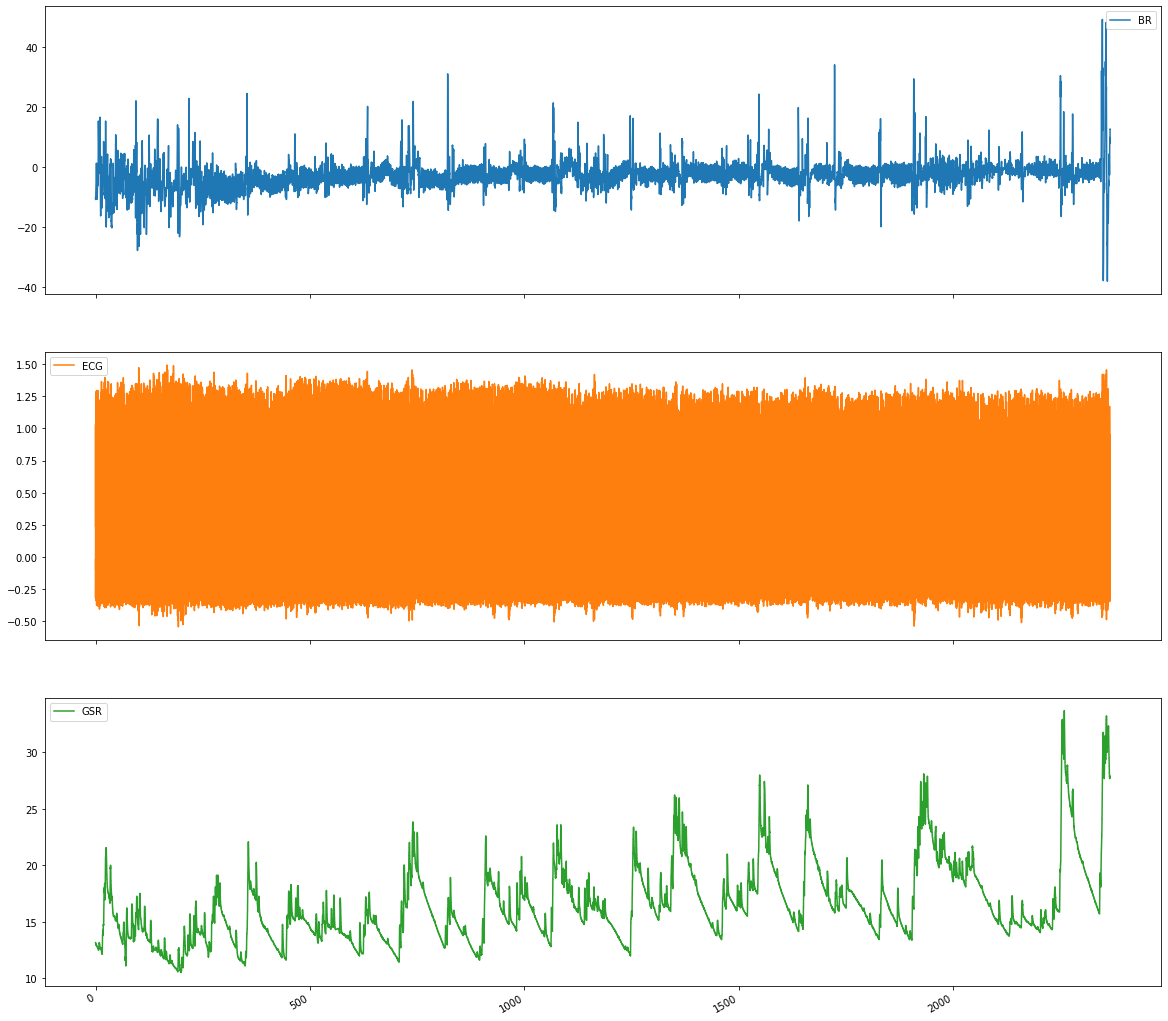

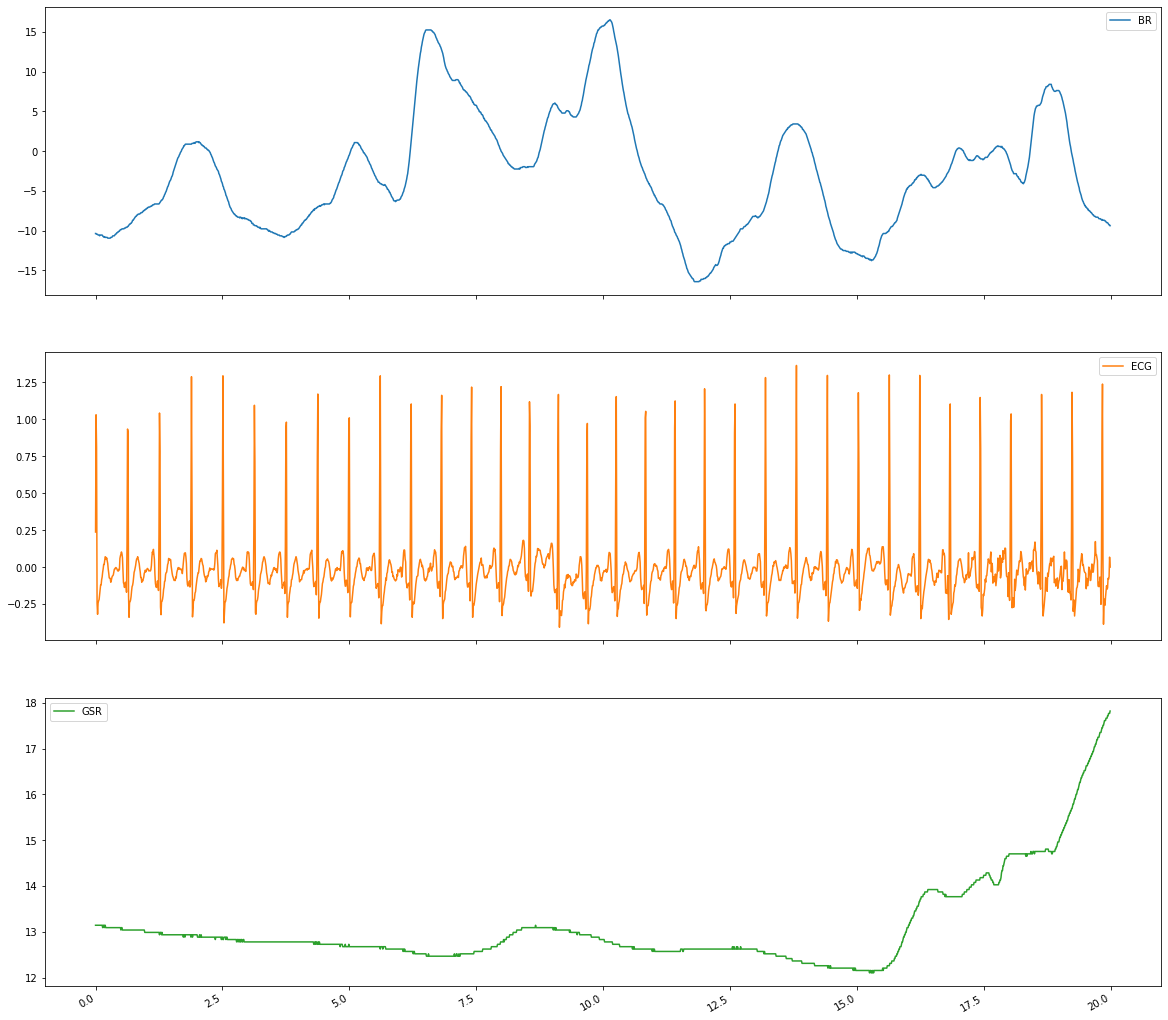

In [10]:
plot_cols = ['BR', 'ECG', 'GSR']
plot_features = df[plot_cols]
plot_features.index = time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:2000]
plot_features.index = time[:2000]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [94]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BR,236693.0,-2.746817,4.899595,-38.183594,-4.980469,-2.636719,-0.683594,49.121094
ECG,236693.0,-0.017141,0.202694,-0.544922,-0.108398,-0.032227,0.020508,1.494141
GSR,236693.0,16.514452,3.461793,10.494552,14.234579,15.844868,18.130440,33.713884


This gives the model access to the most important frequency features. In this case we knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

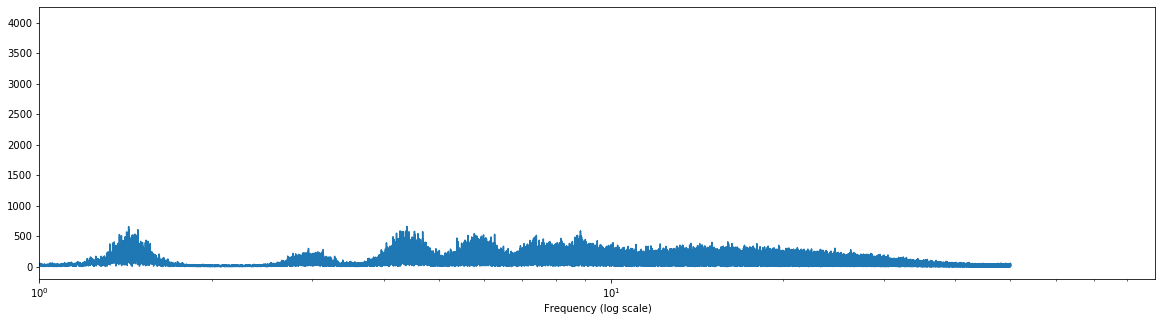

In [95]:
fft = tf.signal.rfft(df['ECG'])
freqs = Fs * np.arange(0, len(fft)) /n

mpl.rcParams['figure.figsize'] = (20, 5)
plt.step(freqs, np.abs(fft))
plt.xscale('log')
# plt.ylim(0, 400000)
plt.xlim([1, max(plt.xlim())])
# plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [8]:
len(train_df)

165685

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that we get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

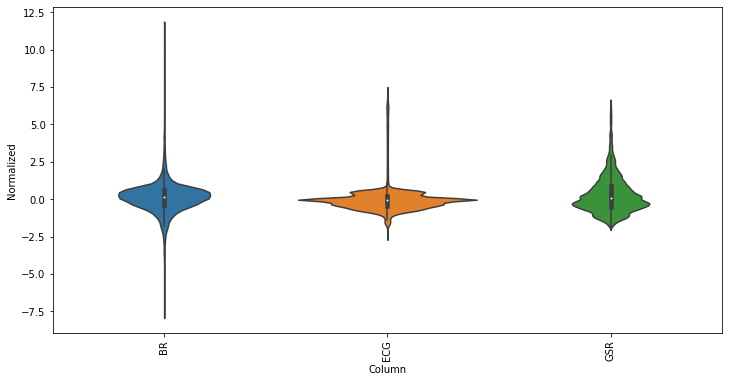

In [11]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [10]:
baseline_column = 'ECG'

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into a `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

In [11]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
              self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col=baseline_column, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
    #   ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        ds = timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [44]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

# Example

That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample. So, create a wider `WindowGenerator` that generates windows 24h of consecutive inputs and labels at a time. 

The `wide_window` doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the `time` axis acts like the `batch` axis: Each prediction is made independently with no interaction between time steps.

### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)

In [13]:
CONV_WIDTH = 200
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[baseline_column])

conv_window

Total window size: 201
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Label indices: [200]
Label column name(s): ['ECG']

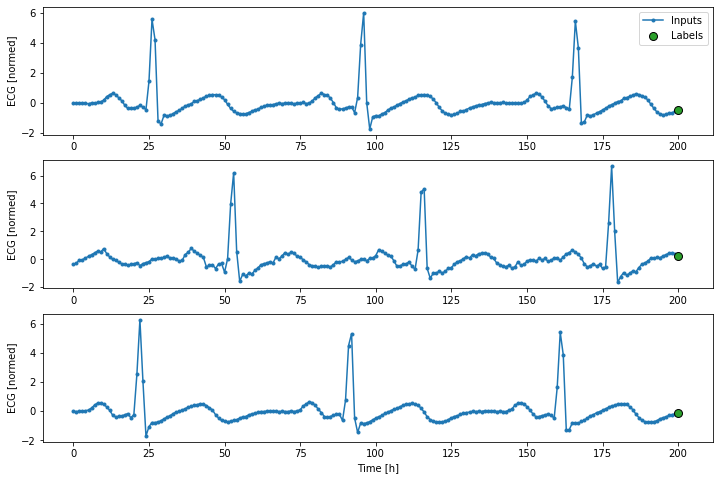

In [37]:
conv_window.plot()

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

### Convolution neural network
 
A convolution layer (`layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `layers.Flatten` and the first `layers.Dense` are replaced by a `layers.Conv1D`.
* The `layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [40]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to see that the model produces outputs with the expected shape:

In [41]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 200, 3)
Output shape: (32, 1, 1)


In [42]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            multiple                  19232     
_________________________________________________________________
dense_2 (Dense)              multiple                  1056      
_________________________________________________________________
dense_3 (Dense)              multiple                  33        
Total params: 20,321
Trainable params: 20,321
Non-trainable params: 0
_________________________________________________________________


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [ ]:
history = compile_and_fit(conv_model, conv_window)

This `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [47]:
LABEL_WIDTH = 200
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[baseline_column])

wide_conv_window

Total window size: 400
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [48]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 399, 3)
Labels shape: (32, 200, 1)
Output shape: (32, 200, 1)


Now you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding timesteps:

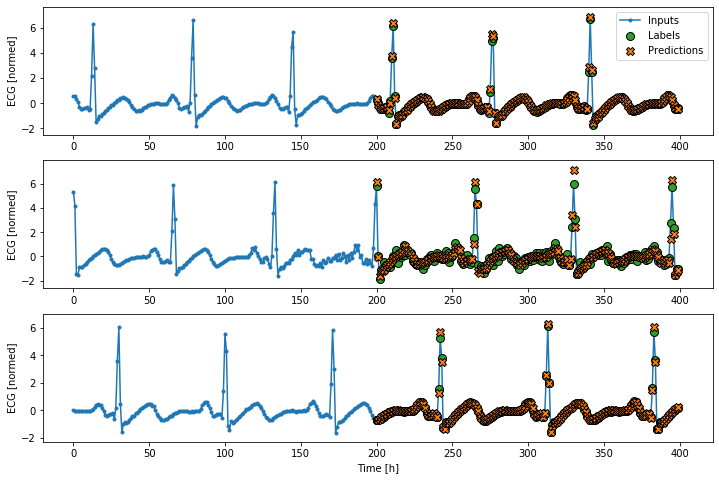

In [49]:
wide_conv_window.plot(conv_model)

In [50]:
inputs_wide, labels_wide = wide_conv_window.example

In [51]:
labels_wide.shape

TensorShape([32, 200, 1])

In [52]:
prediction_wide = conv_model(inputs_wide)

In [53]:
prediction_wide.shape

TensorShape([32, 200, 1])

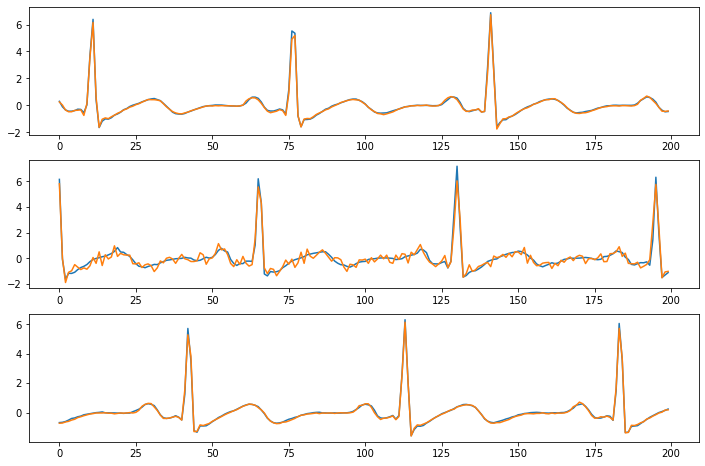

In [54]:
plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(prediction_wide[0,:,0])
plt.plot(labels_wide[0,:,0])
plt.subplot(3,1,2)
plt.plot(prediction_wide[1,:,0])
plt.plot(labels_wide[1,:,0])
plt.subplot(3,1,3)
plt.plot(prediction_wide[2,:,0])
plt.plot(labels_wide[2,:,0])

## explore convolutional

In [66]:
conv_layer = conv_model.layers[0]

In [67]:
dir(conv_layer)

['_TF_MODULE_IGNORED_PROPERTIES', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_activity_regularizer', '_add_inbound_node', '_add_variable_with_custom_getter', '_autocast', '_call_accepts_kwargs', '_call_arg_was_passed', '_call_fn_args', '_callable_losses', '_checkpoint_dependencies', '_clear_losses', '_collect_input_masks', '_compute_causal_padding', '_compute_dtype', '_convolution_op', '_dedup_weights', '_deferred_dependencies', '_dtype', '_dtype_defaulted_to_floatx', '_dtype_policy', '_dynamic', '_eager_add_metric', '_eager_losses', '_expects_mask_arg', '_expects_training_arg', '_flatten', '_gather_children_attribute', '_gather_saveables_for_checkpoint', '_get_call_arg_value',

In [70]:
w_conv = conv_layer.get_weights()

In [90]:
print(w_conv[0].shape)
print(w_conv[1].shape)
patterns = w_conv[0]
biases = w_conv[1]

(200, 3, 32)
(32,)


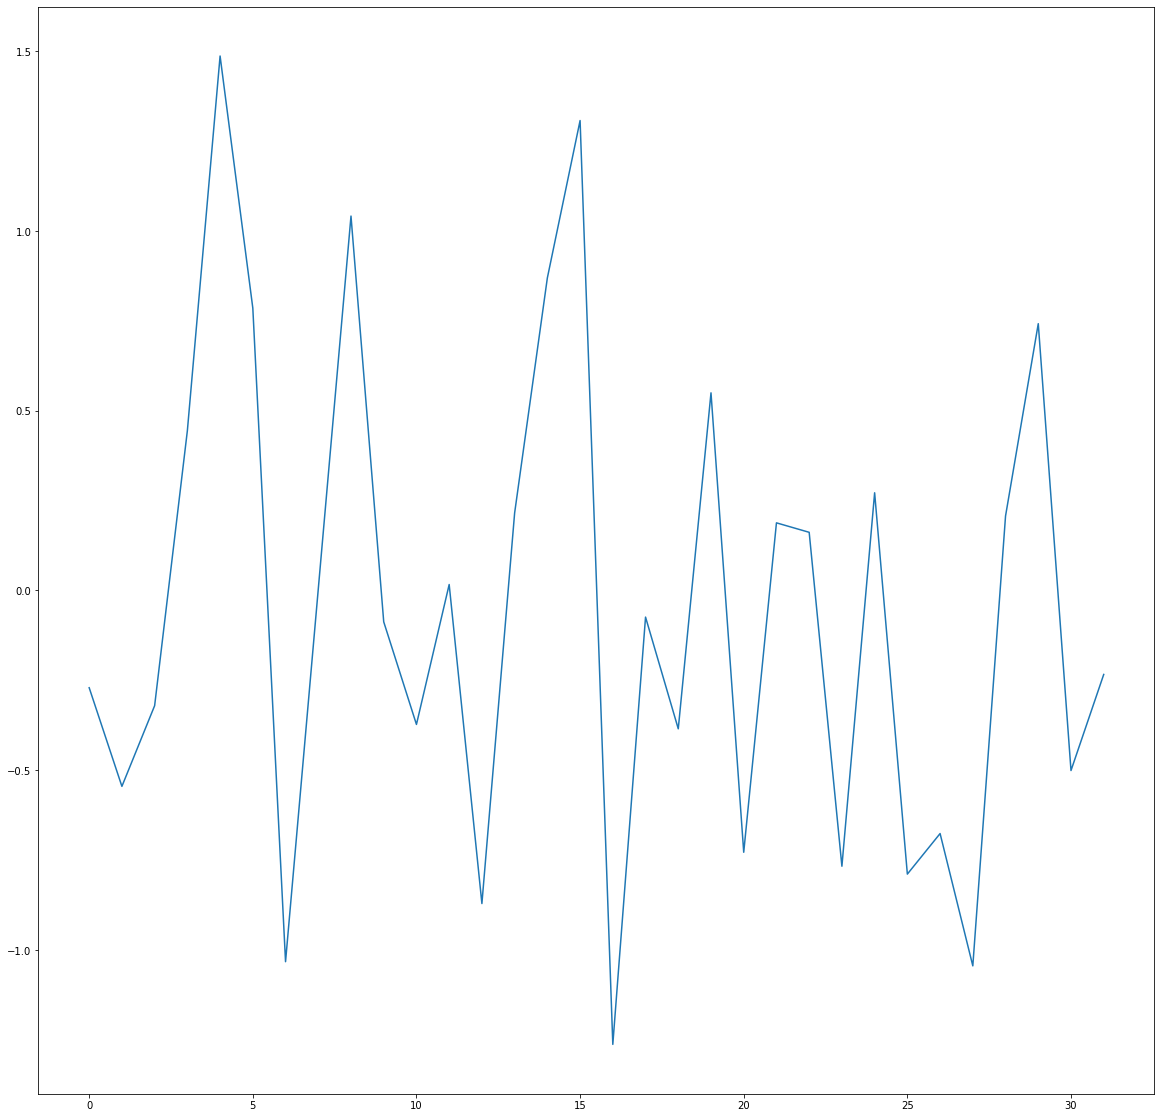

In [93]:
plt.plot(biases)

[<matplotlib.lines.Line2D object at 0x7fb09c35db90>, <matplotlib.lines.Line2D object at 0x7fb09c35dd90>, <matplotlib.lines.Line2D object at 0x7fb09c35df50>]

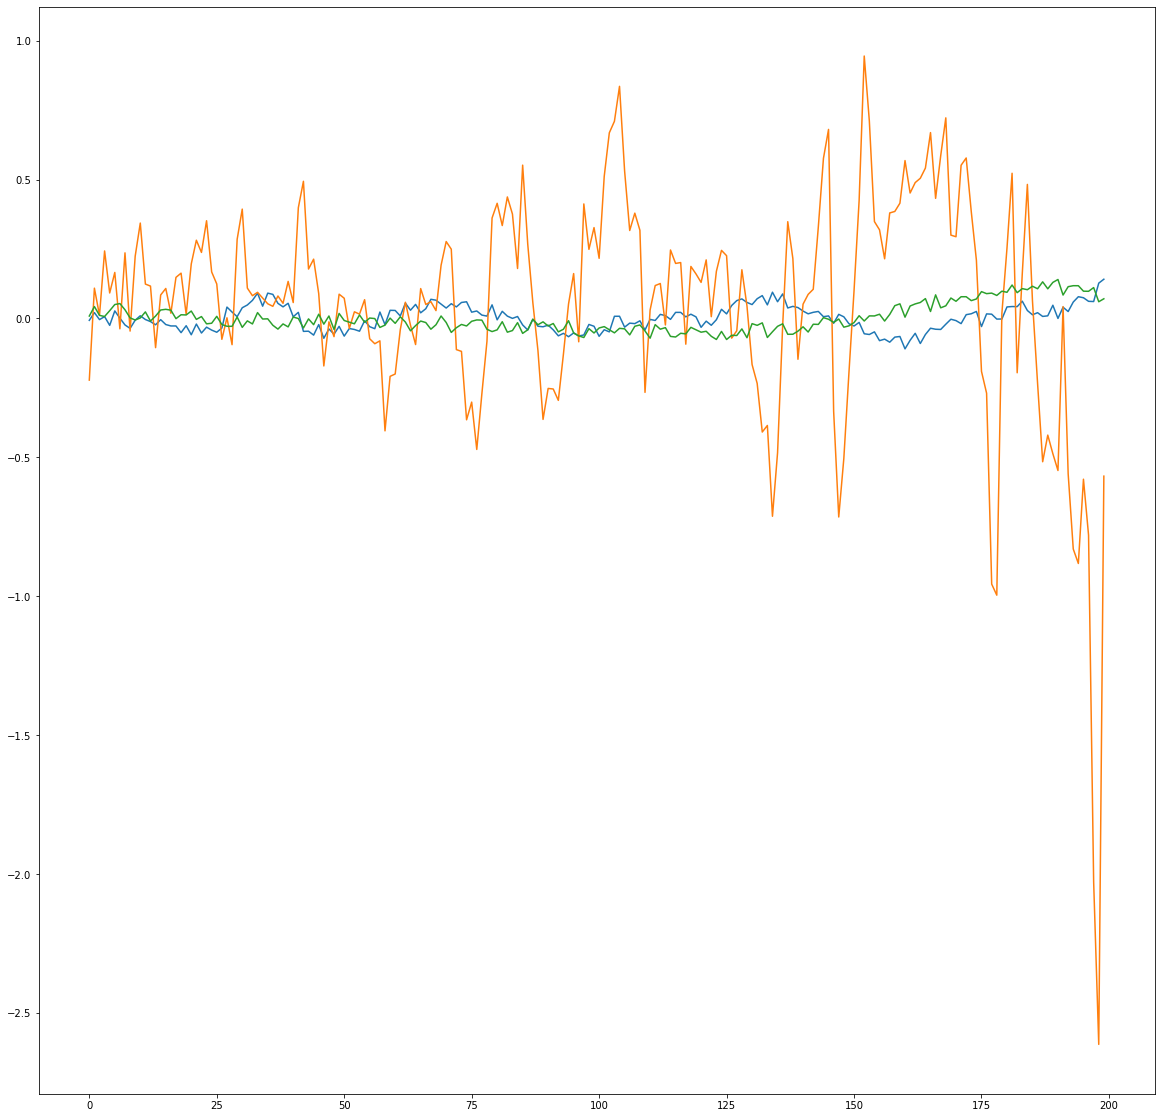

In [89]:
plt.plot(patterns[:,:,11])

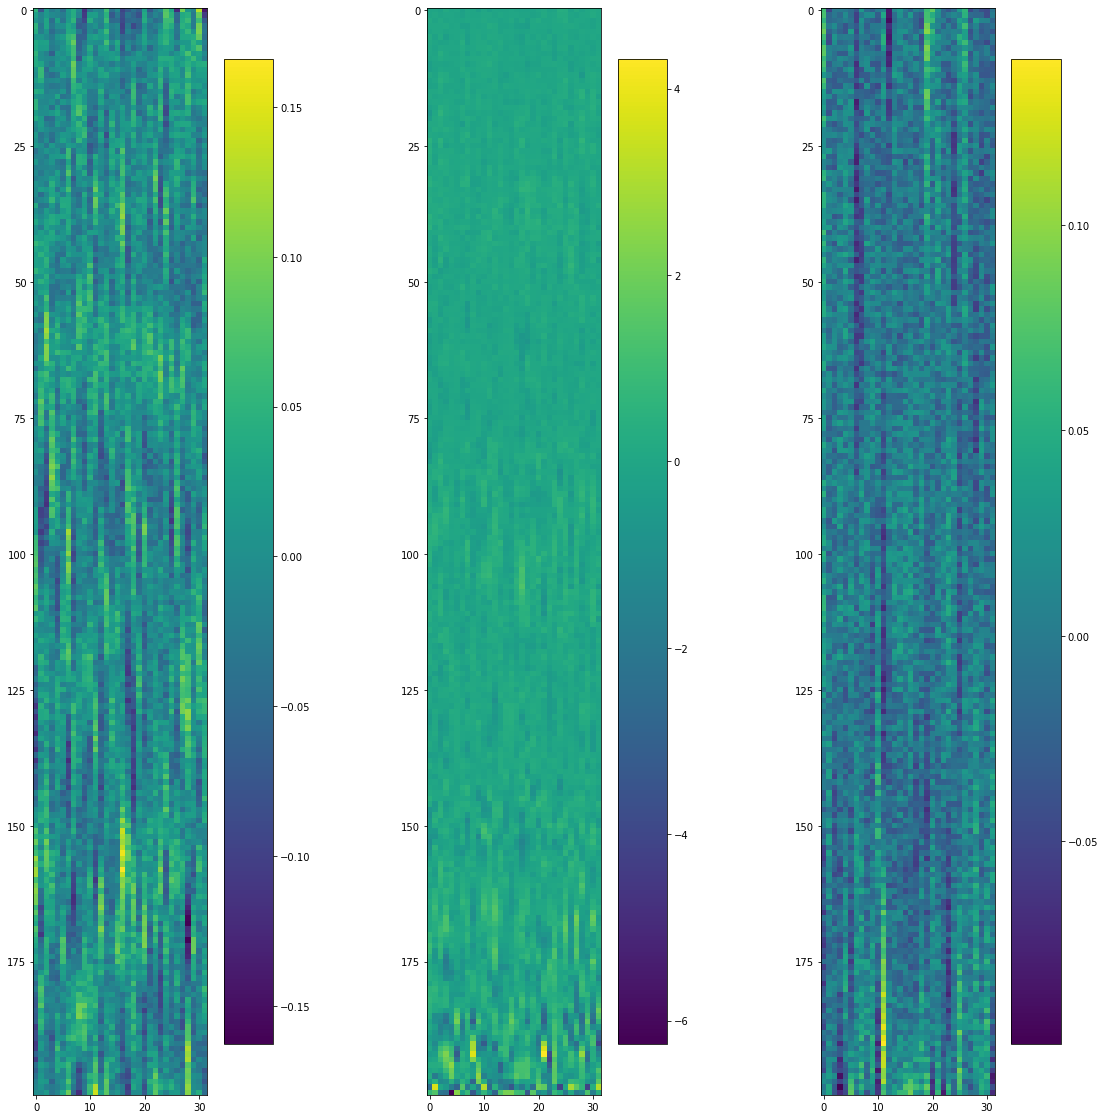

In [92]:
en_bias = 1
plt.subplot(1,3,1)
plt.imshow(patterns[:,0,:])
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(patterns[:,1,:])
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(patterns[:,2,:])
plt.colorbar()

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

For more details, read the [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation) or the [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

In this tutorial, you will use an RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

An important constructor argument for all keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways.

1. If `False`, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction: 

![An lstm warming up and making a single prediction](images/lstm_1_window.png)

2. If `True` the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple timesteps simultaneously.

![An lstm making a prediction after every timestep](images/lstm_many_window.png)

In [109]:
lstm_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)
lstm_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): None

In [110]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True` the model can be trained on 24h of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first timestep the model has no access to previous steps, and so can't do any better than the simple `linear` and `dense` models shown earlier.

In [111]:
history = compile_and_fit(lstm_model, lstm_window)

Epoch 1/20
5177/5177 [==============================] - 68s 13ms/step - loss: 0.6468 - mean_absolute_error: 0.5644 - val_loss: 0.0000e+00 - val_mean_absolute_error: 0.0000e+00
Epoch 2/20
5177/5177 [==============================] - 59s 11ms/step - loss: 0.6370 - mean_absolute_error: 0.5629


KeyboardInterrupt: 

In [112]:
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                multiple                  4608      
_________________________________________________________________
dense_7 (Dense)              multiple                  33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


InvalidArgumentError: slice index 1 of dimension 2 out of bounds. [Op:StridedSlice] name: strided_slice/

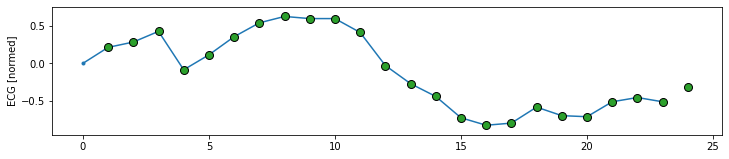

In [113]:
lstm_window.plot(lstm_model)

### Multi-output models

The models so far all predicted a single output feature, baseline_column, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.



In [114]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=200, label_width=200, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 200, 3)
Labels shape (batch, time, features): (32, 200, 3)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of 1.

#### Baseline

The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`.

In [116]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [117]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [118]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

1474/1474 [==============================] - 4s 2ms/step - loss: 0.2519 - mean_absolute_error: 0.1082


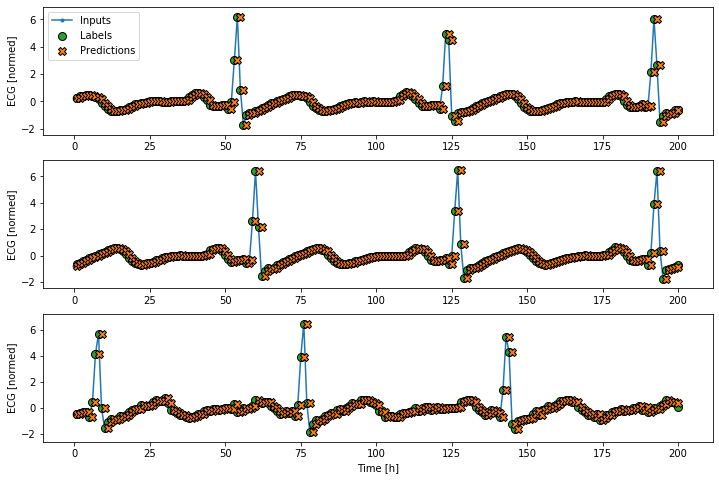

In [119]:
wide_window.plot(baseline)

#### Dense

In [120]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [121]:
history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

1480/1480 [==============================] - 6s 4ms/step - loss: 0.1633 - mean_absolute_error: 0.0990


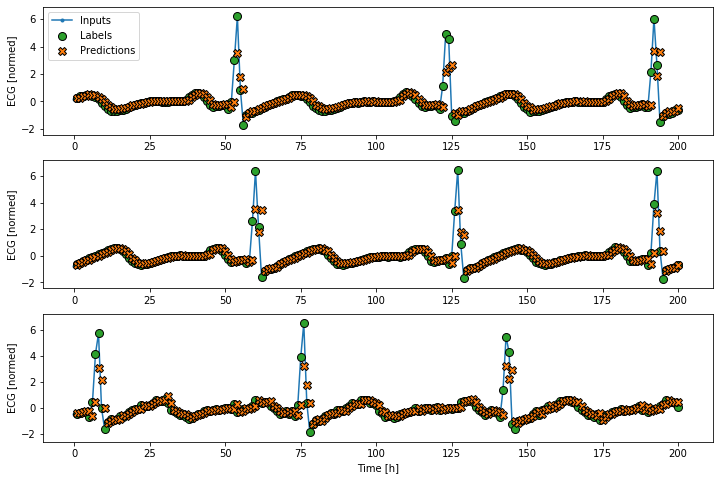

In [122]:
wide_window.plot(dense)

#### RNN



In [123]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)


Epoch 1/20
5172/5172 [==============================] - 138s 27ms/step - loss: 0.0357 - mean_absolute_error: 0.0672 - val_loss: 0.0000e+00 - val_mean_absolute_error: 0.0000e+00
Epoch 2/20
5172/5172 [==============================] - 131s 25ms/step - loss: 0.0101 - mean_absolute_error: 0.0400 - val_loss: 0.0088 - val_mean_absolute_error: 0.0376
Epoch 3/20
5172/5172 [==============================] - 131s 25ms/step - loss: 0.0088 - mean_absolute_error: 0.0368 - val_loss: 0.0081 - val_mean_absolute_error: 0.0360
Epoch 4/20
5172/5172 [==============================] - 130s 25ms/step - loss: 0.0081 - mean_absolute_error: 0.0350 - val_loss: 0.0077 - val_mean_absolute_error: 0.0347
Epoch 5/20
5172/5172 [==============================] - 130s 25ms/step - loss: 0.0077 - mean_absolute_error: 0.0339 - val_loss: 0.0074 - val_mean_absolute_error: 0.0331
Epoch 6/20
5172/5172 [==============================] - 130s 25ms/step - loss: 0.0074 - mean_absolute_error: 0.0331 - val_loss: 0.0072 - val_mean_a

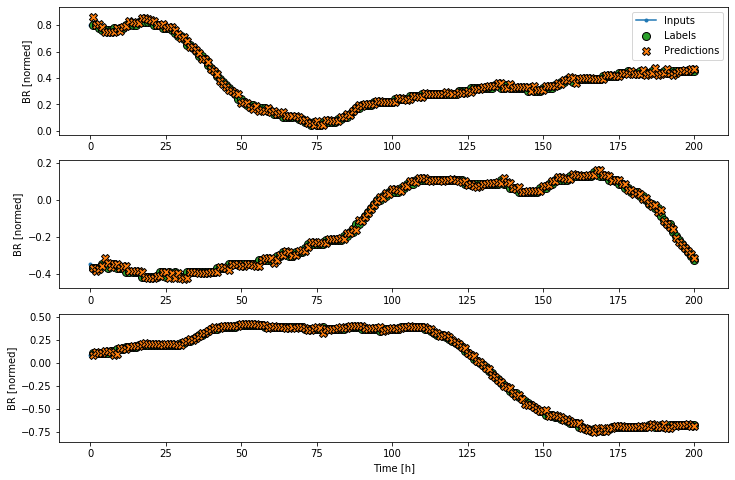

In [131]:
wide_window.plot(lstm_model,plot_col='BR')

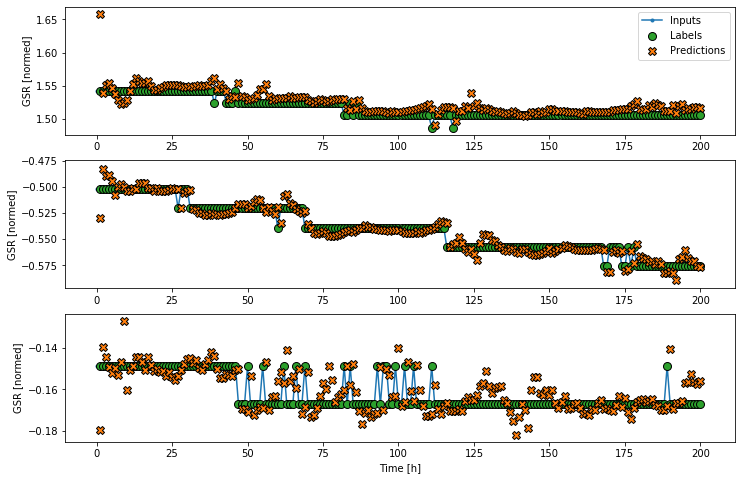

In [132]:
wide_window.plot(lstm_model,plot_col='GSR')

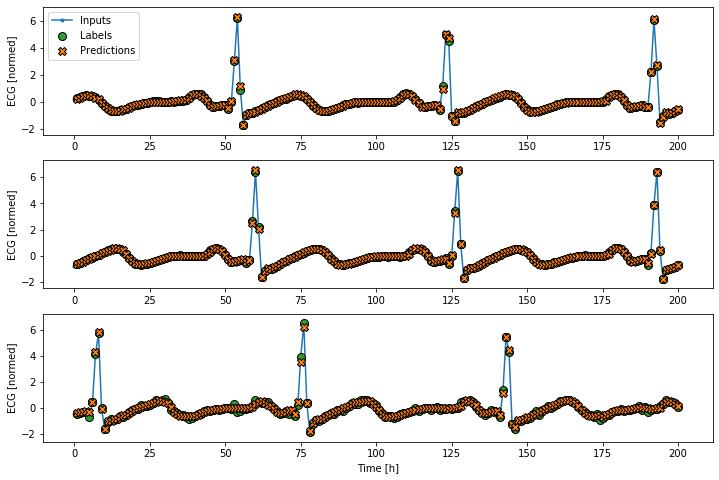

In [133]:
wide_window.plot(lstm_model,plot_col='ECG')

In [126]:
lstm_model.save('networks')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: networks/assets


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict the how the value will change in the next timestep.
Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [134]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [136]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

Epoch 1/20
5172/5172 [==============================] - 133s 26ms/step - loss: 0.0264 - mean_absolute_error: 0.0467 - val_loss: 0.0000e+00 - val_mean_absolute_error: 0.0000e+00
Epoch 2/20
5172/5172 [==============================] - 127s 24ms/step - loss: 0.0095 - mean_absolute_error: 0.0345 - val_loss: 0.0082 - val_mean_absolute_error: 0.0333
Epoch 3/20
5172/5172 [==============================] - 131s 25ms/step - loss: 0.0085 - mean_absolute_error: 0.0331 - val_loss: 0.0077 - val_mean_absolute_error: 0.0318
Epoch 4/20
5172/5172 [==============================] - 128s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0323 - val_loss: 0.0075 - val_mean_absolute_error: 0.0308
Epoch 5/20
5172/5172 [==============================] - 126s 24ms/step - loss: 0.0077 - mean_absolute_error: 0.0317 - val_loss: 0.0073 - val_mean_absolute_error: 0.0303
Epoch 6/20
5172/5172 [==============================] - 130s 25ms/step - loss: 0.0075 - mean_absolute_error: 0.0313 - val_loss: 0.0072 - val_mean_a

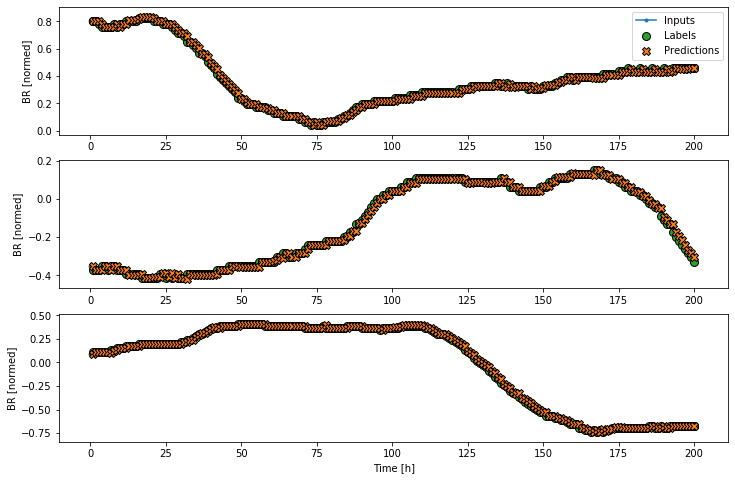

In [138]:
wide_window.plot(residual_lstm,plot_col='BR')

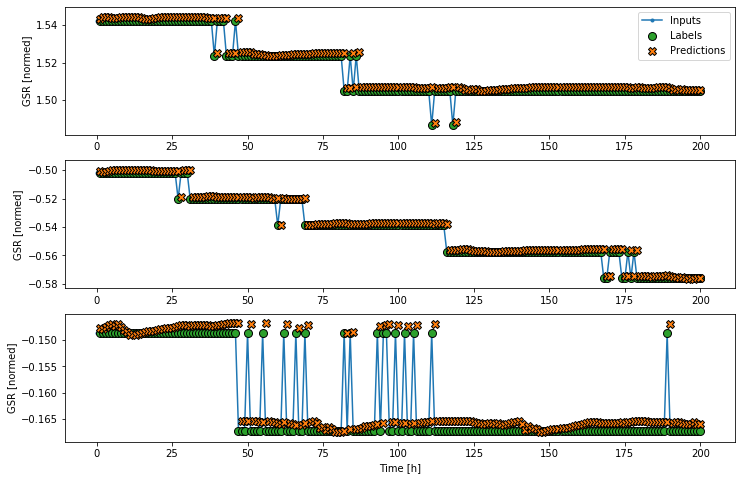

In [139]:
wide_window.plot(residual_lstm,plot_col='GSR')

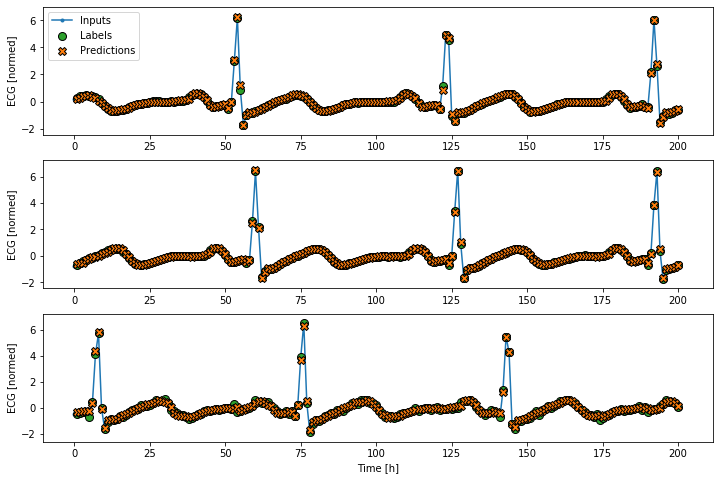

In [137]:
wide_window.plot(residual_lstm)

In [144]:
residual_lstm.save_weights('networks/rlstm_200/')

#### Performance

Here is the overall performance for these multi-output models.

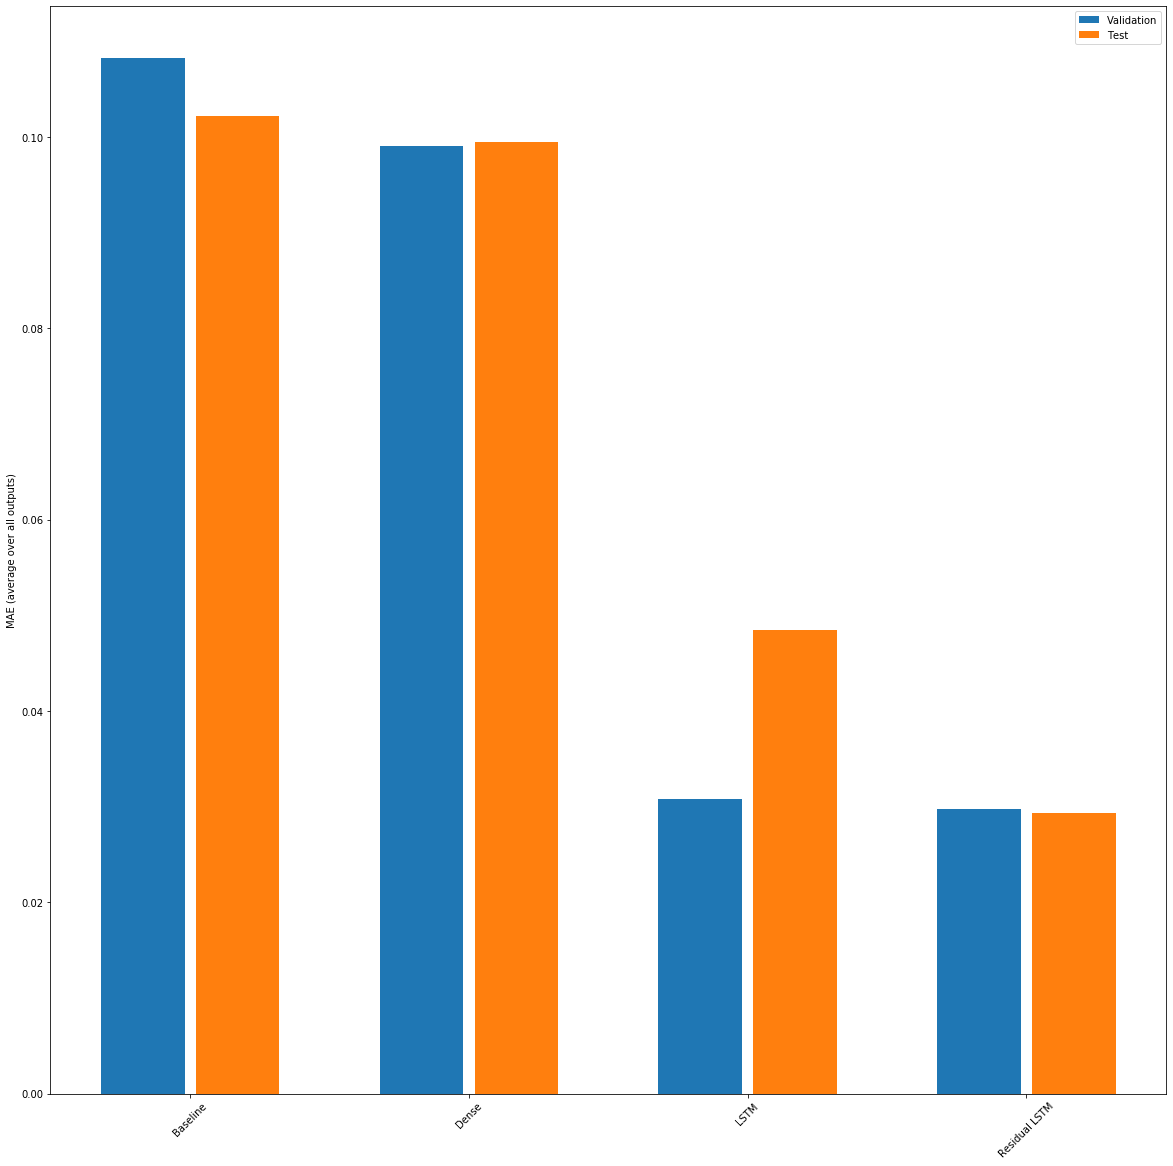

In [140]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [141]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1021
Dense          : 0.0994
LSTM           : 0.0484
Residual LSTM  : 0.0293


The above performances are averaged across all model outputs.